<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate Toy Dataset


In [33]:
import sklearn
from sklearn.datasets import make_circles

#choose number of samples
n_samples=1000

#create circles
x,y=make_circles(n_samples,
                 noise=0.02,
                 random_state=66)

In [34]:
len(x), len(y)

(1000, 1000)

In [35]:
print(x[:5])
print(y[:5])

[[-0.72974363  0.68637738]
 [ 0.66264716 -0.44070676]
 [-0.25925316  0.77418256]
 [-0.48943149 -0.61886408]
 [ 0.08215533  1.04318507]]
[0 1 1 1 0]


In [36]:
import pandas as pd
circle_data=pd.DataFrame({"x_1":x[:,0],
                         "x_2":x[:,1],
                         "label":y})
circle_data.head()

,x_1,x_2,label
0,-0.729744,0.686377,0
1,0.662647,-0.440707,1
2,-0.259253,0.774183,1
3,-0.489431,-0.618864,1
4,0.082155,1.043185,0


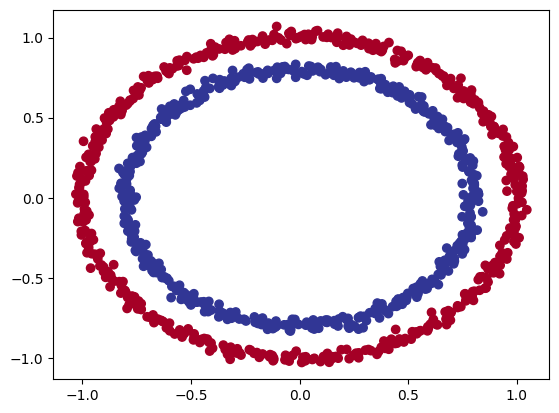

In [37]:
#Visulaizing data
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y, #colour deided by the value in y
            cmap=plt.cm.RdYlBu)#cmap sets the color map based on value of y

Check input and output shapes


In [38]:
x.shape,y.shape

((1000, 2), (1000,))

In [39]:
print("sample x value", x[0])
print("sample y value", y[0])

sample x value [-0.72974363  0.68637738]
sample y value 0


Turn data into tensors


In [40]:
import torch
torch.__version__

'2.1.0+cu121'

In [41]:
type(x)

numpy.ndarray

In [42]:
#Turn into tensor
x_tensor=torch.from_numpy(x).type(torch.float)
y_tensor=torch.from_numpy(y).type(torch.float)#float will convert to float32 by default
type(x_tensor),type(y_tensor),x_tensor.dtype,y_tensor.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [43]:
#split into training and test dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test= train_test_split(x_tensor,
                                                y_tensor,
                                                test_size=0.2) #20% of whole dataset)

In [44]:
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

Building a model


In [45]:
import torch
from torch import nn
#make device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now, the following steps will be done:
1. Make a subclass of nn.Module
2. Create 2 nn.Linear layers that are capable of handling shapes of our data
3. Define a forward() method based on forward computation required
4. Make an instance of the subclass and send to target device

In [46]:
x_train.shape, y_train.shape #small side note: shape here is not a method but an attribute of ndarray thats why no ()

(torch.Size([800, 2]), torch.Size([800]))

In [47]:
class Circle_Model(nn.Module):
  def __init__(self):
    super().__init__()
    #in_features and out_features selected based on shape of x_train and y_train
    self.layer_1=nn.Linear(in_features=2, out_features=5)#takes 2 features (the coordinates) and gives out a specific number of features chosen by out_features parameter
    self.layer_2=nn.Linear(in_features=5, out_features=1)#takes features produced by first layer and gives 1 feature

    #define forward pass
    def forward(self,x):
      return self.layer_2(self.layer_1(x)) #x goes through first layer then second layer then gives output

#make an instance of our model
model_0=Circle_Model().to(device)
model_0

Circle_Model(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [48]:
device

'cpu'

In [49]:
(next(model_0.parameters())).device# parameters() method in nn.Module returns an iterable over the parameters of the model, next() function is used to iterate once over the  iterable, hence reaching its fist value which is returned, .device is an attribute of nn.Module returning the device which the accessed parameter is stored in

device(type='cpu')

In [50]:
type(model_0.parameters())

generator

In [51]:
#replicating the model using nn.Sequential

model_0=nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0# figure out how to change dtype of weights of a model

#makes essentially the same neural network as was made above as subclass of nn.Module
#using this will make all the required layers of the network at once while defining attributes of subclass in nn.Module insteead of defining each individually
#use this when network to be made is simple, if network is very customized use code like above making subclasses

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [52]:
#make untrained predictions
with torch.inference_mode():
  untrained_pred=model_0(x_test)
print("shape of untrained predictions:", untrained_pred.shape)
print("shape of test sample", x_test.shape)
print("first 10 predictions", torch.round(untrained_pred[:10]))
print("first 10 y_test", y_test[:10])


shape of untrained predictions: torch.Size([200, 1])
shape of test sample torch.Size([200, 2])
first 10 predictions tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]])
first 10 y_test tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])


Setting up Loss Function and Optimizer:
Which ones to use?
1. For Regression: MAE or MSE is generally used.
2. For Classificaiton: Binary Cross Entropy or Categorical Cross Entropy is used generally
3. Optimizer: Most useful ones are SGD and Adam

In [53]:
#here will use BCE with Sigmoid function built in
loss_fn=nn.BCEWithLogitsLoss()# read its documentaiton
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [54]:
#calculate accuracy
def accuracy_calc(y_true, y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()#eq function makes a boolean tensor with True wherever both values are equal, sum() method adds up all elements and returns a tensor, item() method returns the numerical value of the values in tensor
  acc=(correct/len(y_pred))*100# in percentage
  return acc

Train Model:
1. Forward Pass
2. Calculate Loss
3. Set Optimizer Zero Grad
4. BackPropogation
5. Gradient Descent


In [84]:
model_0.eval() #putting in evaluation mode
#havent started the training loop yet still manually seeing how training will go
with torch.inference_mode():
  y_logits=model_0(x_test)
print(y_logits[:5])
len(y_logits)

tensor([[ 0.0946],
        [-0.0123],
        [ 0.0733],
        [ 0.0576],
        [ 0.0685]])


200

In [85]:
y_test[:5]

tensor([0., 0., 0., 1., 0.])

In [86]:
y_pred_probs=torch.sigmoid(y_logits)# using sigmoid activation function
print(y_pred_probs[:5])
len(y_pred_probs)

tensor([[0.5236],
        [0.4969],
        [0.5183],
        [0.5144],
        [0.5171]])


200

In [87]:
#Calculating prediction 2 diff ways
y_preds=torch.round(y_pred_probs)
# now in full
y_preds_again= torch.round(torch.sigmoid(model_0(x_test)))
#checking for equality
print(torch.eq(y_preds.squeeze(),y_preds_again.squeeze()))
#getting rid of extra dimension in prediction
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0.])

In [88]:
#making training loop
torch.manual_seed(40)
torch.cuda.manual_seed(40)

#set number of epochs
epochs=100

#put data to target device
x_train, y_train= x_train.to(device), y_train.to(device)
x_test, y_test= x_test.to(device),y_test.to(device)

#starting loop
for epoch in range(epochs):
  #Training
  model_0.train()

  #1. Forward Pass
  y_logits=model_0(x_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #2. Calculate Loss
  #loss_fn is calculated from the values coming from activation function without rounding off, calculating after rounding off wouldnt make sense because after a point it would become 0 and training would stop there and the model wont be as accurate
  loss= loss_fn(y_logits,#here loss_fn function is used which uses BCEWithLogitsLoss, as it has sigmoid function built in it requires raw logits
                y_train)
  #loss= loss_fn(torch.sigmoid(y_logits), #if loss_fn is defined using nn.BCELoss instead of the way it is defined above, then raw logits need to be converted to prediction probabilities to put in BCELoss function
  #              y_train)
  acc=accuracy_calc(y_true=y_train,
                  y_pred=y_pred)
  #3. optimizer zero grad
  optimizer.zero_grad()

  #4. loss backward (backpropogation)
  loss.backward()

  #5. optimizer step (gradient descent)
  optimizer.step()

  #Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits=model_0(x_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #2. Calculating loss
    test_loss= loss_fn(test_logits,
                       y_test)
    test_acc=accuracy_calc(y_true=y_test,
                           y_pred=test_pred)
  if epoch%10==0:
    print("Epoch:", epoch, "Training Loss:", loss.item(), "Training Accuracy:", acc, "Test Loss:", test_loss.item(), "Test Accuracy:", test_acc)


Epoch: 0 Training Loss: 0.692775547504425 Training Accuracy: 57.75 Test Loss: 0.6963915228843689 Test Accuracy: 50.5
Epoch: 10 Training Loss: 0.6927752494812012 Training Accuracy: 57.49999999999999 Test Loss: 0.6964037418365479 Test Accuracy: 49.5
Epoch: 20 Training Loss: 0.6927751302719116 Training Accuracy: 57.375 Test Loss: 0.6964149475097656 Test Accuracy: 49.5
Epoch: 30 Training Loss: 0.6927749514579773 Training Accuracy: 57.25 Test Loss: 0.6964253783226013 Test Accuracy: 49.5
Epoch: 40 Training Loss: 0.6927748918533325 Training Accuracy: 57.25 Test Loss: 0.6964349150657654 Test Accuracy: 49.5
Epoch: 50 Training Loss: 0.6927748322486877 Training Accuracy: 57.125 Test Loss: 0.6964438557624817 Test Accuracy: 49.5
Epoch: 60 Training Loss: 0.6927746534347534 Training Accuracy: 57.125 Test Loss: 0.6964520215988159 Test Accuracy: 49.5
Epoch: 70 Training Loss: 0.6927745342254639 Training Accuracy: 57.25 Test Loss: 0.6964595913887024 Test Accuracy: 49.5
Epoch: 80 Training Loss: 0.69277453

In [89]:
#as can be seen accuracy remains very close to 50% so something seems wrong
#lets check using helper functions
#read what this helper function does from the link

In [90]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


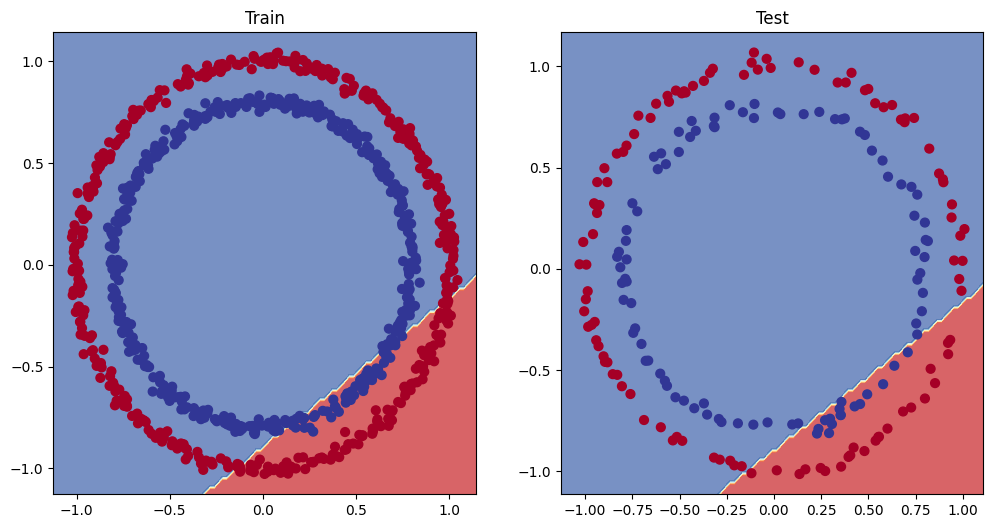

In [91]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)#why 1,2,2 here?
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

In [92]:
#above graph makes it clear using linear layers is causing the problems as the boundary formed will be linear only